In [5]:
import json
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn.metrics import average_precision_score, precision_recall_curve, auc, roc_curve

import sys
sys.path.append('..')
from lib import *
from numba import njit

plt.style.use('../peptidome.mplstyle')

In [6]:
proteome = 'Humanviruses'
all_data = {}
for i, model in enumerate(['independent', 'ncov', 'nskew', 'nskewfcov']):

    arr = np.load('data/{proteome}_{model}_k9_likelihoods.npz'.format(proteome=proteome, model=model))
    data = {}

    logp_hh, logp_pp, logp_hp, logp_ph = arr['logp_hh'], arr['logp_pp'], arr['logp_hp'], arr['logp_ph']
    data['logp_hh'], data['logp_pp'], data['logp_hp'], data['logp_ph'] = logp_hh, logp_pp, logp_hp, logp_ph

    positive = logp_pp-logp_ph
    negative = logp_hp-logp_hh#[np.random.randint(len(logp_hh), size=len(positive)*negative_excess)]
    y_true = np.concatenate([np.ones(len(positive)), np.zeros(len(negative))])
    y_score = np.concatenate([positive, negative])
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    data['fpr'], data['tpr'], data['roc_auc'] = fpr, tpr, roc_auc
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)

    data['precision'], data['recall'], data['average_precision'] = precision, recall, average_precision

    all_data[model] = data
negative_excess = len(logp_hh)/len(logp_pp)

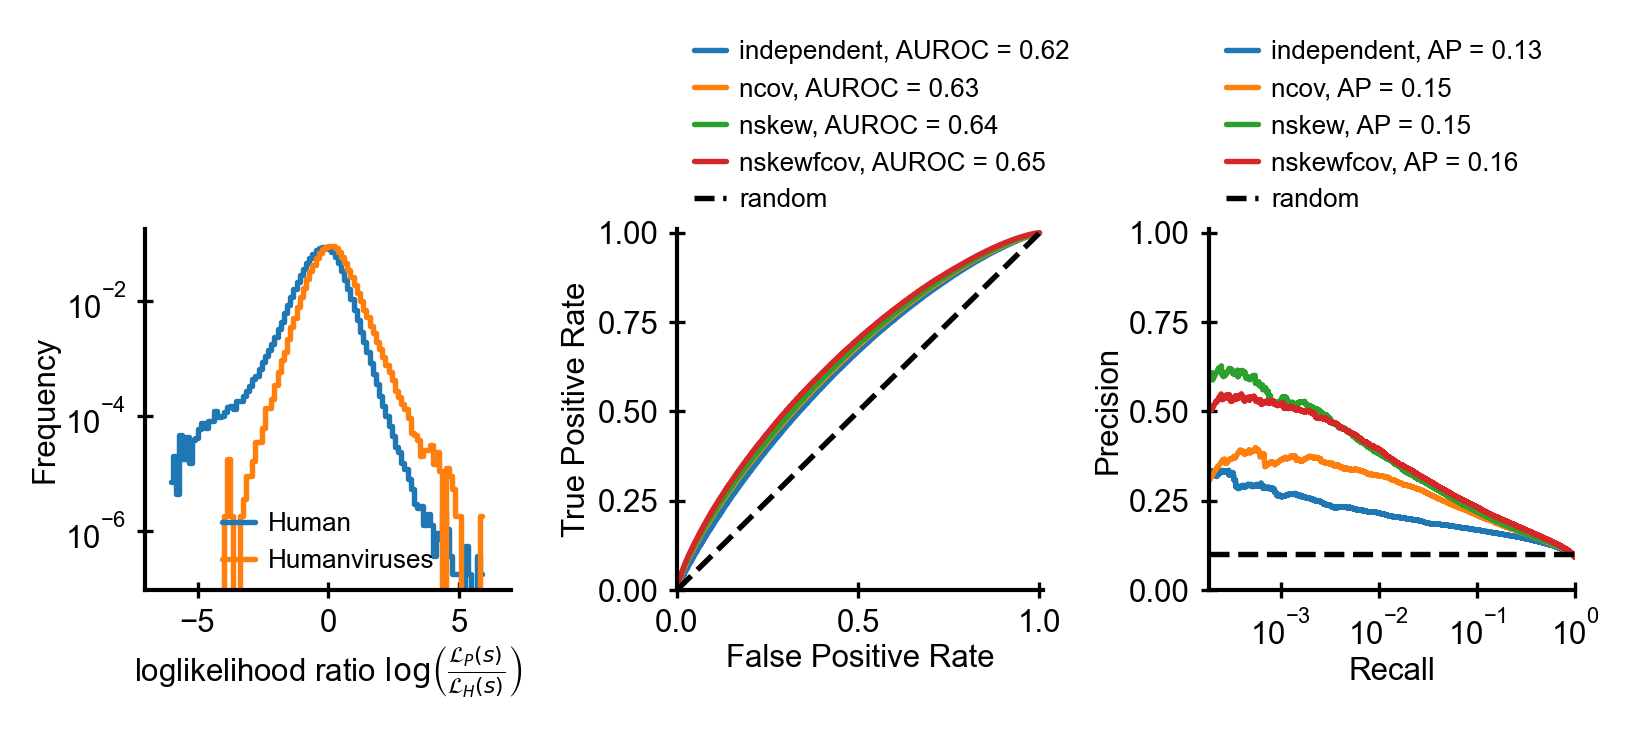

In [7]:
fig, axes = plt.subplots(figsize=(5.5, 2.5), ncols=3, nrows=1)

ax = axes[0]
plot_histograms([negative, positive], ['Human', proteome], xmin=-6, xmax=6, ax=ax, nbins=100)
ax.set_xlabel(r'loglikelihood ratio $\log \left( \frac{\mathcal{L}_P(s)}{\mathcal{L}_H(s)} \right)$')
ax.set_yticks([])
ax.set_ylabel('Frequency')
ax.set_xlim(-7, 7)
#ax.set_ylim(0.0)
ax.set_yscale('log')
ax.legend(loc='lower center')

plot_kwargs = dict()#lw=0.8

ax = axes[1]
for model, data in all_data.items():
    ax.plot(data['fpr'], data['tpr'],
            label='{model}'.format(model=model)+', AUROC = %0.2f' % data['roc_auc'],
            **plot_kwargs)
ax.plot([0, 1], [0, 1], color='k', linestyle='--', label='random')
ax.set_xlim(0.0, 1.01)
ax.set_ylim(0.0, 1.01)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower left", bbox_to_anchor=(0.0, 1.0))

ax = axes[2]
for model, data in all_data.items():
    ax.plot(data['recall'], data['precision'],
            label='{model}'.format(model=model)+', AP = {0:0.2f}'.format(data['average_precision']),
            **plot_kwargs)
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.axhline(1.0/negative_excess, c='k', ls='--', label='random')
ax.set_ylim(0.0, 1.01)
#ax.set_xlim(0.0, 1.01)
ax.set_xscale('log')
ax.set_xticks(10.0**np.arange(-4, 1, 1))
ax.set_xlim(100/len(logp_pp), 1.0)
ax.legend(loc='lower left', bbox_to_anchor=(0.0, 1.0))

fig.tight_layout()
